# Metadata

```
Course:   DS 5001 
Module:   08 Lab
Topic:    LDA with SciKit Learn
Authpor:  R.C. Alvarado

Purpose:  In this notebook we create a topic model from our corpus using SciKit Learn's library.
```

# Set Up

In [1]:
data_home = "../data"
local_lib = "../lib"
data_prefix = 'austen-melville'

In [2]:
n_terms = 1000
n_topics = 20
max_iter = 20
# n_top_terms = 7
doc_topic_prior = .1 # Prior of document topic distribution alpha. Defaults to 1 / n_components.
topic_word_prior = .1 # Prior of topic word distribution beta. Defaults to 1 / n_components.

In [3]:
BAG = ['book_id', 'chap_id']

In [4]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Prepare Data

We work with the count matrix.

In [ ]:
BOW = pd.read_csv(f'{data_home}/output/{data_prefix}-BOW.csv').set_index(BAG+['term_str'])
# VOCAB = pd.read_csv(f'{data_home}/output/{data_prefix}-VOCAB2.csv').set_index('term_str')
LIB = pd.read_csv(f'{data_home}/output/{data_prefix}-LIB2.csv').set_index('book_id')

In [6]:
LIB['auth'] = LIB.author.apply(lambda x: x.split(',')[0])

In [7]:
LIB.head()

,source_file_path,author,title,chap_regex,book_len,n_chaps,genre,mood,label,auth
book_id,,,,,,,,,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,domestic,romance,AUSTEN–PERSUASION–D–105,AUSTEN
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,gothic,satire,AUSTEN–NORTHANGER–G–121,AUSTEN
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,domestic,satire,AUSTEN–MANSFIELD –D–141,AUSTEN
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,domestic,romance,AUSTEN–EMMA–D–158,AUSTEN
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,"AUSTEN, JANE",SENSE AND SENSIBILIT,^CHAPTER\s+\d+$,119873,50,domestic,romance,AUSTEN–SENSE AND –D–161,AUSTEN


In [8]:
# DOC = pd.DataFrame(index=X.index).join(LIB[['auth','title', 'genre']])
# DOC['label'] = DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()} ({x.genre[:1]}) {x.name[0]}:{x.name[1]}", 1)

# Define a Topic Model Class

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

class TopicModel():            

    bow_count_col:str = 'n'
    n_topics:int = 20
    n_top_terms:int = None
    engine_type = 'LDA' # Also NMF
    n_terms = 1000

    # LDA Params
    max_iter:int = 20
    learning_offset:float = 50.
    random_state:int = 0
    
    # NMF Params
    nmf_init = 'nndsvd'
    nmf_max_iter = 1000
    
    def __init__(self, BOW:pd.DataFrame):
        self.BOW = BOW
        self.LIB = LIB
        
    def create_X(self):
        X = self.BOW[self.bow_count_col].unstack()
        V = X.count().to_frame('df')
        X = X.fillna(0)
        V['idf'] = np.log2(len(X)/V.df)
        V['dfidf'] = V.df * V.idf
        SIGS = V.sort_values('dfidf', ascending=False).head(self.n_terms).index
        self.X = X[SIGS]
        self.V = V              
        
    def get_model(self):
        
        if self.engine_type == 'LDA':
            self.engine = LDA(n_components=self.n_topics, 
                                  max_iter=self.max_iter, 
                                  learning_offset=self.learning_offset, 
                                  random_state=self.random_state)

        elif self.engine_type == 'NMF':
            self.engine = NMF(n_components=self.n_topics, 
                                  max_iter=self.nmf_max_iter,
                                  init=self.nmf_init, 
                                  random_state=1, 
                                  alpha=.1, 
                                  l1_ratio=.5)
                
        self.THETA = pd.DataFrame(self.engine.fit_transform(self.X.values), index=self.X.index)
        self.THETA.columns.name = 'topic_id'
        
        self.PHI = pd.DataFrame(self.engine.components_, columns=self.X.columns)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
        self.TOPIC = self.PHI.sum(1).to_frame('phi_sum')
        self.TOPIC['theta_sum'] = self.THETA.sum()

    def describe_topics(self):
        
        PHI_P = (self.PHI.T / self.PHI.T.sum())
        PHI_I = np.log2(1/PHI_P)
        self.TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)
        if not self.n_top_terms:
            self.n_top_terms = round(self.TOPIC.h.mean())
            
        # Compute relevant terms
        self.get_relevant_terms(0)            

        self.TOPIC['top_terms'] = self.PHI.stack().to_frame('topic_weight')\
            .groupby('topic_id')\
            .apply(lambda x: 
                x.sort_values('topic_weight', ascending =False)\
                    .head(self.n_top_terms)\
                    .reset_index()['term_str'])\
            .apply(lambda x: ' '.join(x.replace(' ', '_')), 1)
        
        # Not using top terms from above; using from get_relevant_terms()
        self.TOPIC['label'] = self.TOPIC.apply(lambda x: f"{x.name}: {x.top_terms_rel}", 1)
                
    def get_relevant_terms(self, 𝜆 = .5):
        """
        Compute relevance of topic terms as defined by Sievert and Shirley 2014.
        C. Sievert and K. Shirley, “LDAvis: A Method for Visualizing and Interpreting Topics,” 
        in Proceedings of the workshop on interactive language learning, visualization, and interfaces, 2014, pp. 63–70.
        """
        Ptw = self.PHI.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
        Pw = self.PHI.sum() / self.PHI.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
        self.REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
        self.TOPIC['top_terms_rel'] = self.REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)

    def get_model_stats(self):
        # p = self.TOPIC.theta_sum / self.TOPIC.theta_sum.sum()
        self.entropy = self.TOPIC.h.sum()
        self.redundancy = 1 - self.entropy / np.log2(self.n_topics)
    
    def get_doc_stats(self):
        self.DOC = (self.THETA.T * np.log2(1/self.THETA.T)).sum().to_frame('entropy')
        self.DOC['max_topic'] = self.THETA.idxmax(1)
        
    def plot_topics(self):
        self.TOPIC.sort_values('theta_sum', ascending=True).plot.barh(y='theta_sum', x='label', figsize=(5, self.n_topics/2))

## Create separate indexes

In [10]:
AUS_IDX = LIB[LIB.auth == 'AUSTEN'].index
MEL_IDX = LIB[LIB.auth == 'MELVILLE'].index

## Austen

In [11]:
tm_aus = TopicModel(BOW.loc[AUS_IDX])
tm_aus.n_topics = n_topics
tm_aus.engine_type = 'LDA'
tm_aus.create_X()
tm_aus.get_model()
tm_aus.describe_topics()
tm_aus.get_model_stats()
tm_aus.get_doc_stats()

In [12]:
tm_aus.DOC = BOW.loc[AUS_IDX].groupby(['book_id','chap_id']).n.sum().to_frame().join(LIB[['auth','title', 'genre']])
tm_aus.DOC['label'] = tm_aus.DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()} ({x.genre[:1]}) {x.name[0]}:{x.name[1]}", 1)

In [13]:
tm_aus.DOC.head()

n    auth       title     genre  \
book_id chap_id                                       
105     1        2625  AUSTEN  PERSUASION  domestic   
        2        1974  AUSTEN  PERSUASION  domestic   
        3        2837  AUSTEN  PERSUASION  domestic   
        4        1805  AUSTEN  PERSUASION  domestic   
        5        3322  AUSTEN  PERSUASION  domestic   

                                        label  
book_id chap_id                                
105     1        AUSTEN, PERSUASION (d) 105:1  
        2        AUSTEN, PERSUASION (d) 105:2  
        3        AUSTEN, PERSUASION (d) 105:3  
        4        AUSTEN, PERSUASION (d) 105:4  
        5        AUSTEN, PERSUASION (d) 105:5

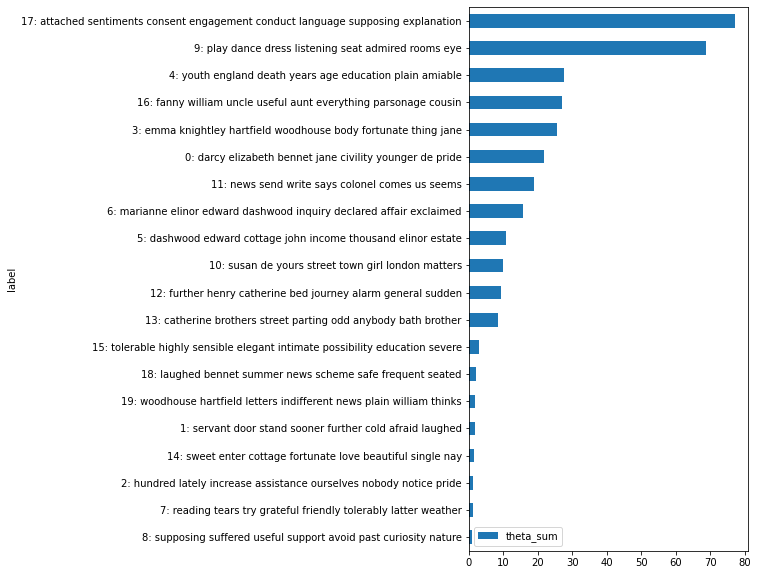

In [14]:
tm_aus.plot_topics()

## Melville

In [15]:
tm_mel = TopicModel(BOW.loc[MEL_IDX])
tm_mel.n_topics = n_topics
tm_mel.create_X()
tm_mel.get_model()
tm_mel.describe_topics()
tm_mel.get_model_stats()
tm_mel.get_doc_stats()

In [16]:
tm_mel.DOC = BOW.loc[MEL_IDX].groupby(['book_id','chap_id']).n.sum().to_frame().join(LIB[['auth','title', 'genre']])
tm_mel.DOC['label'] = tm_mel.DOC.apply(lambda x: f"{x.auth}, {x.title[:10].strip()} ({x.genre[:1]}) {x.name[0]}:{x.name[1]}", 1)

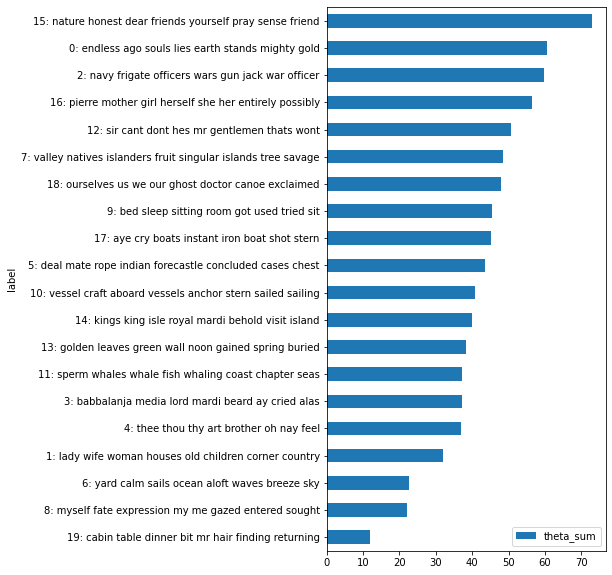

In [17]:
tm_mel.plot_topics()

# Visualize

## Heatmaps of Mean Topic per Book

In [146]:
MEL_IMG = tm_mel.THETA.groupby('book_id').mean()
MEL_IMG.index = LIB.loc[MEL_IDX].label
MEL_IMG.columns = tm_mel.TOPIC.label

In [147]:
MEL_IMG.T.style.background_gradient(cmap='GnBu')

label,MELVILLE–TYPEE A RO–T–1900,MELVILLE–MOBY DICK –S–2701,MELVILLE–OMOO ADVEN–T–4045,MELVILLE–REDBURN HI–S–8118,MELVILLE–WHITE JACK–S–10712,MELVILLE–MARDI AND –S–13720,MELVILLE–MARDI AND –S–13721,MELVILLE–ISRAEL POT–H–15422,MELVILLE–THE CONFID–T–21816,MELVILLE–PIERRE OR –G–34970
label,,,,,,,,,,
0: endless ago souls lies earth stands mighty gold,0.037312,0.084085,0.024230,0.058311,0.045179,0.075705,0.078769,0.101586,0.048087,0.129287
1: lady wife woman houses old children corner country,0.018264,0.021120,0.072980,0.053941,0.022464,0.026641,0.020289,0.080137,0.065391,0.031313
2: navy frigate officers wars gun jack war officer,0.012522,0.026032,0.032661,0.057632,0.470557,0.007937,0.001369,0.074128,0.017298,0.006273
3: babbalanja media lord mardi beard ay cried alas,0.000712,0.001747,0.001450,0.008246,0.009429,0.062231,0.299242,0.001781,0.012072,0.002899
4: thee thou thy art brother oh nay feel,0.003243,0.057830,0.000147,0.007912,0.003111,0.030075,0.066691,0.000830,0.011221,0.155789
5: deal mate rope indian forecastle concluded cases chest,0.008760,0.048117,0.122121,0.099251,0.040113,0.052519,0.019140,0.008202,0.066330,0.016075
6: yard calm sails ocean aloft waves breeze sky,0.002991,0.033336,0.006380,0.052712,0.034821,0.047283,0.038042,0.000105,0.015750,0.003510
7: valley natives islanders fruit singular islands tree savage,0.536154,0.013550,0.157080,0.032814,0.011589,0.031677,0.013487,0.062451,0.033378,0.022391
8: myself fate expression my me gazed entered sought,0.096675,0.008131,0.013855,0.024210,0.020857,0.053213,0.032385,0.004773,0.022761,0.018382


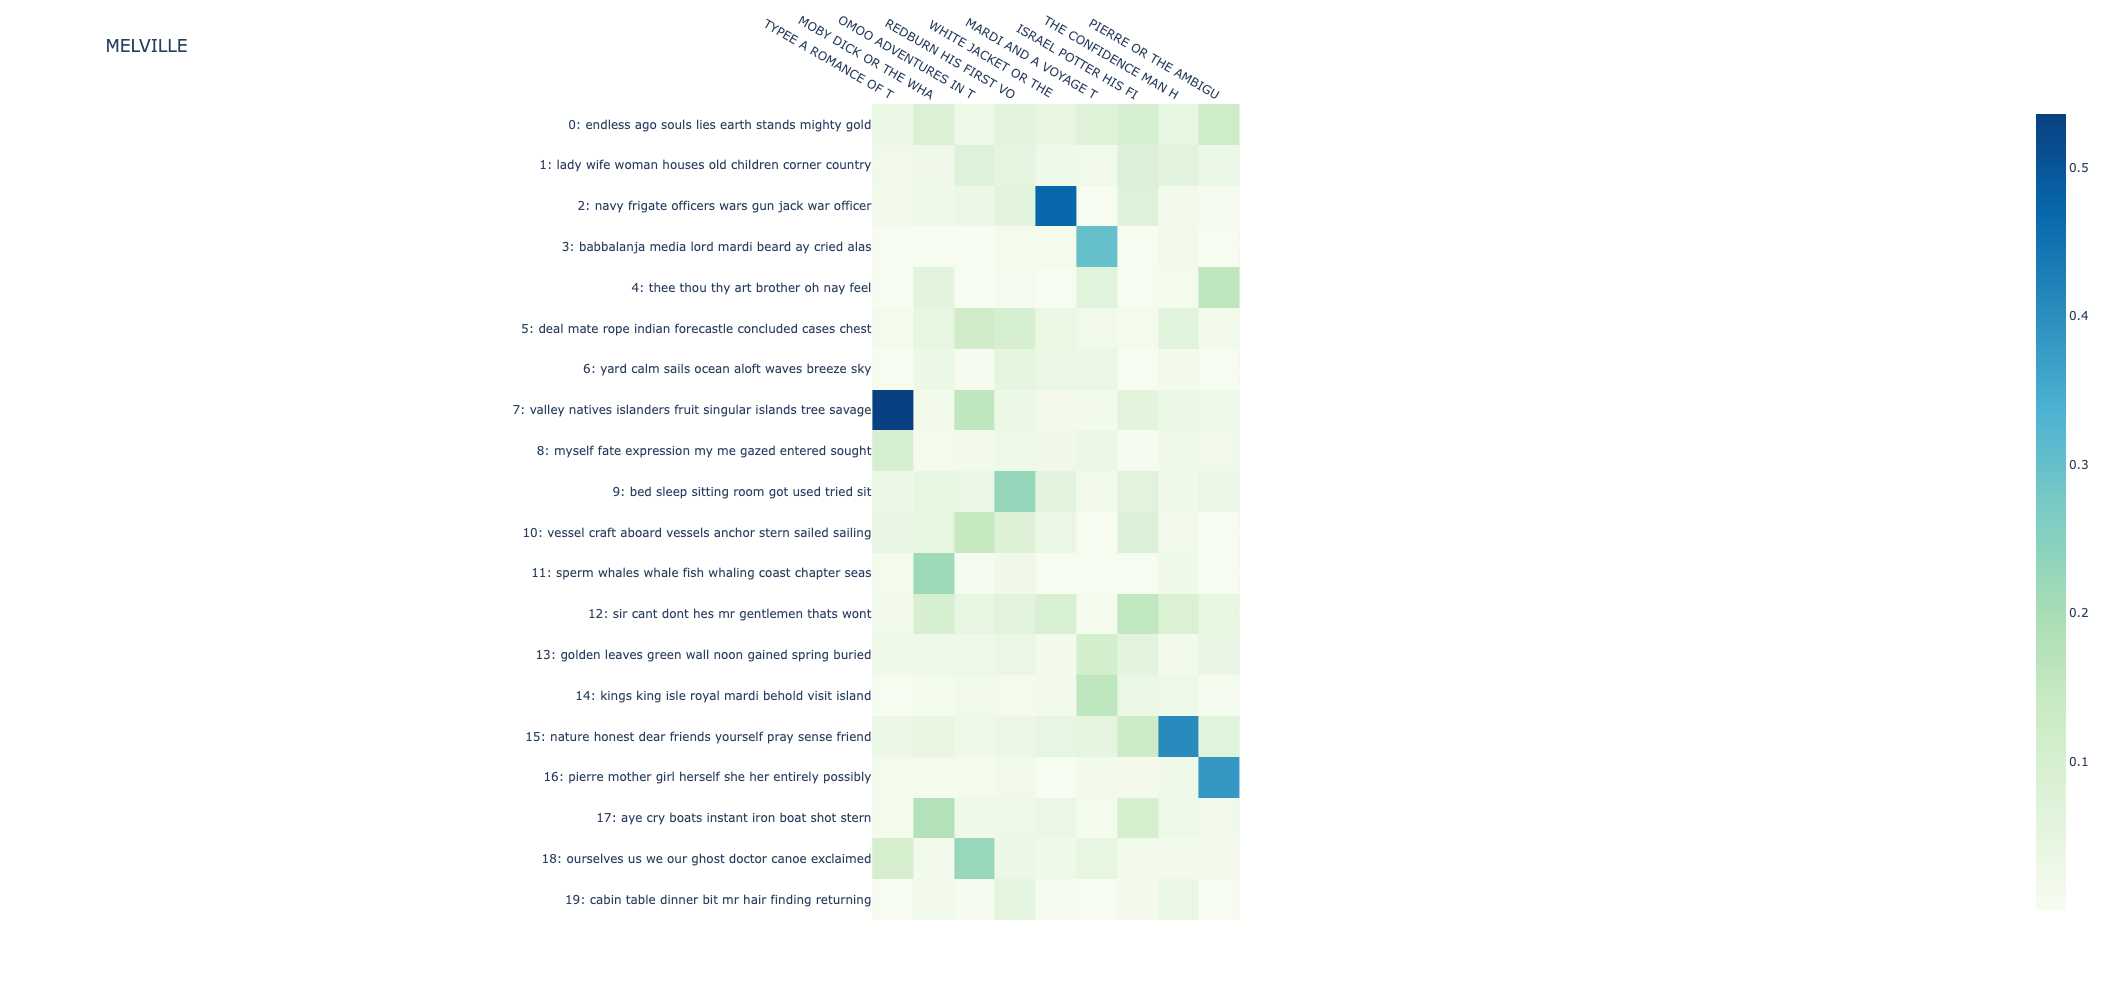

In [135]:
fig = px.imshow(MEL_IMG.T, color_continuous_scale='GnBu', title="MELVILLE", height=1000)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

In [136]:
AUS_IMG = tm_aus.THETA.groupby('book_id').mean()
AUS_IMG.index = LIB.loc[AUS_IDX].title
AUS_IMG.columns = tm_aus.TOPIC.label

In [144]:
AUS_IMG.T.style.background_gradient(cmap='GnBu')

title,PERSUASION,NORTHANGER ABBEY,MANSFIELD PARK,EMMA,SENSE AND SENSIBILIT,LADY SUSAN,LOVE AND FREINDSHIP,PRIDE AND PREJUDICE
label,,,,,,,,
0: darcy elizabeth bennet jane civility younger de pride,0.022400,0.000889,0.000076,0.001169,0.000103,0.002584,0.011909,0.339166
1: servant door stand sooner further cold afraid laughed,0.000080,0.000107,0.000076,0.000089,0.000103,0.005879,0.059309,0.000128
2: hundred lately increase assistance ourselves nobody notice pride,0.000080,0.000107,0.000076,0.018240,0.002735,0.002603,0.000631,0.000128
3: emma knightley hartfield woodhouse body fortunate thing jane,0.000496,0.000107,0.000076,0.460889,0.000272,0.000652,0.000631,0.000128
4: youth england death years age education plain amiable,0.106474,0.044071,0.043838,0.059343,0.030256,0.090958,0.435217,0.042564
5: dashwood edward cottage john income thousand elinor estate,0.000593,0.002738,0.000528,0.001935,0.187507,0.012196,0.011654,0.005334
6: marianne elinor edward dashwood inquiry declared affair exclaimed,0.000080,0.000107,0.000076,0.000089,0.276743,0.000652,0.070246,0.000128
7: reading tears try grateful friendly tolerably latter weather,0.000080,0.000107,0.000076,0.000089,0.023570,0.000652,0.000631,0.000128
8: supposing suffered useful support avoid past curiosity nature,0.000080,0.000107,0.000076,0.000089,0.000103,0.000652,0.039092,0.000128


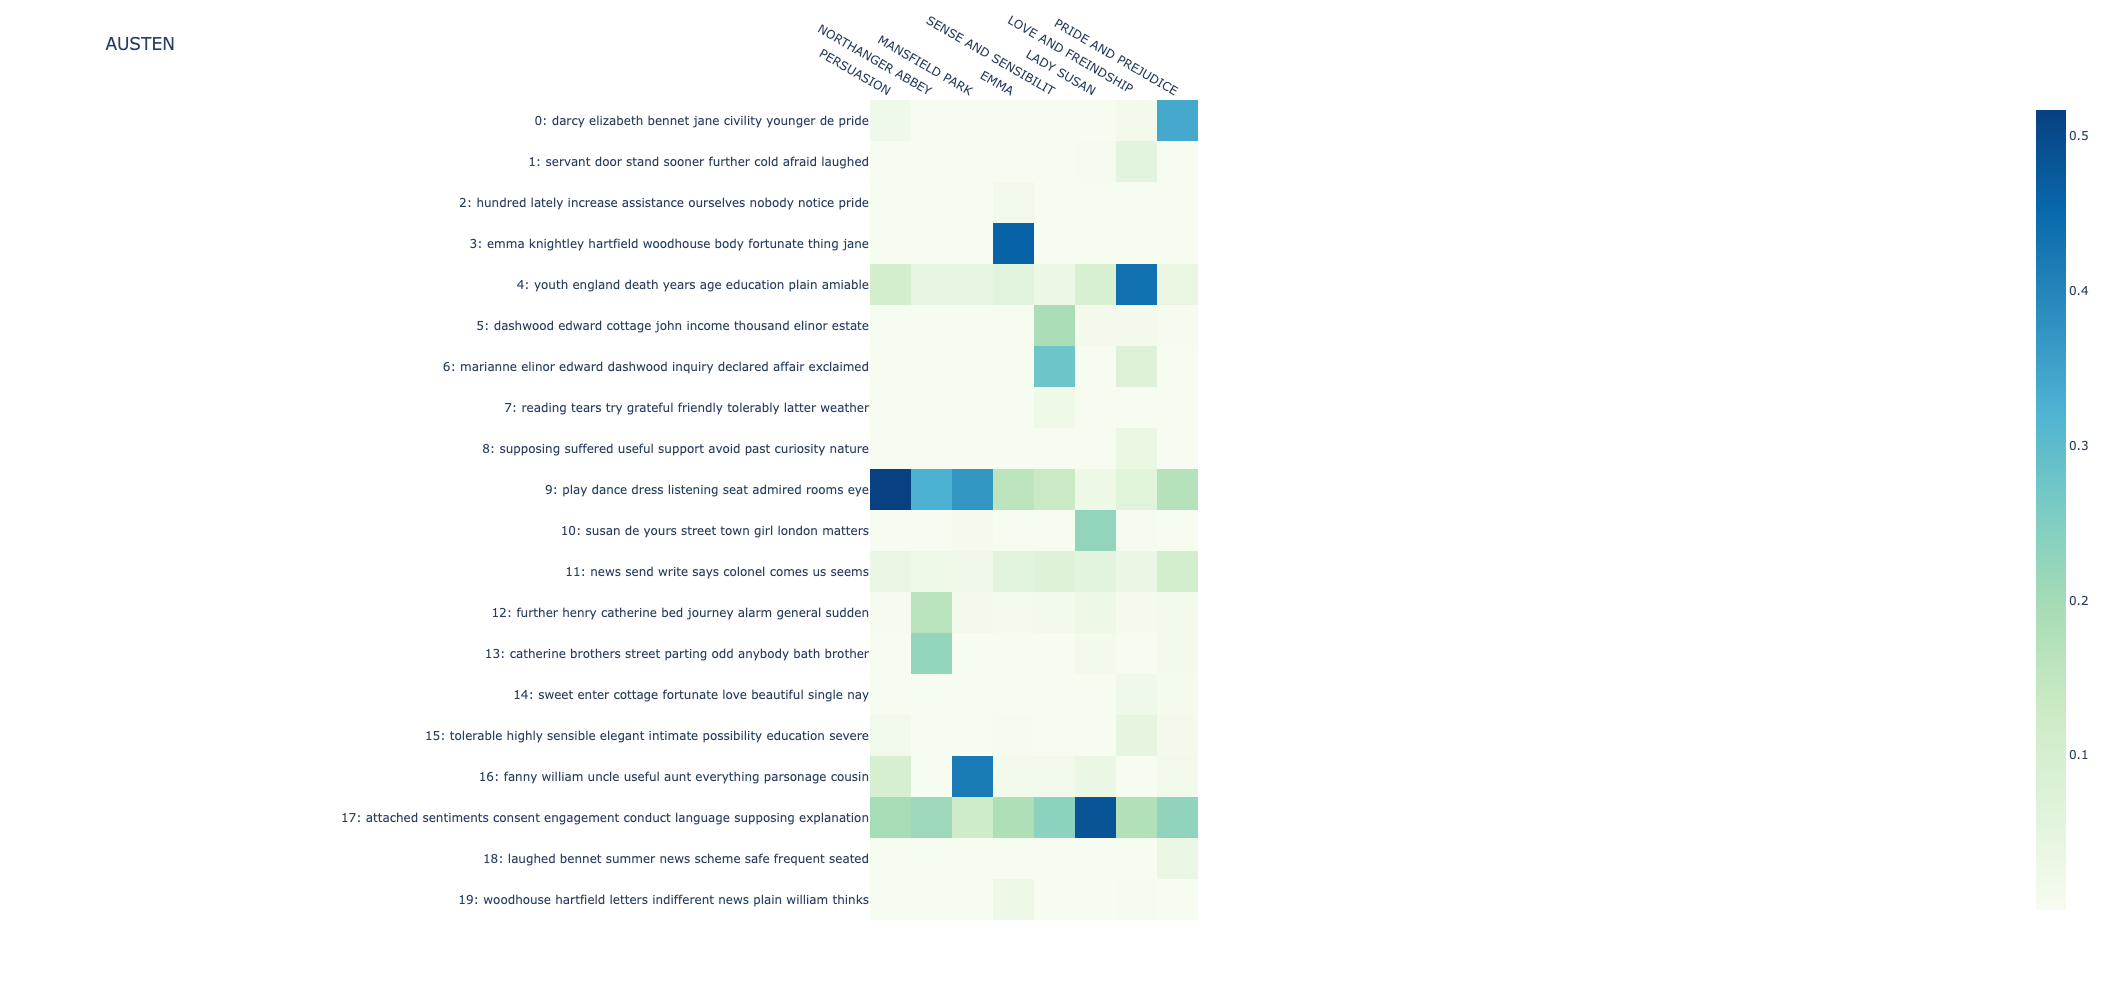

In [137]:
fig = px.imshow(AUS_IMG.T, color_continuous_scale='GnBu', height=1000, title="AUSTEN")
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

## Topic Dendrograms

In [26]:
import sys; sys.path.append(local_lib)

In [27]:
from hac2 import HAC

<Figure size 432x288 with 0 Axes>

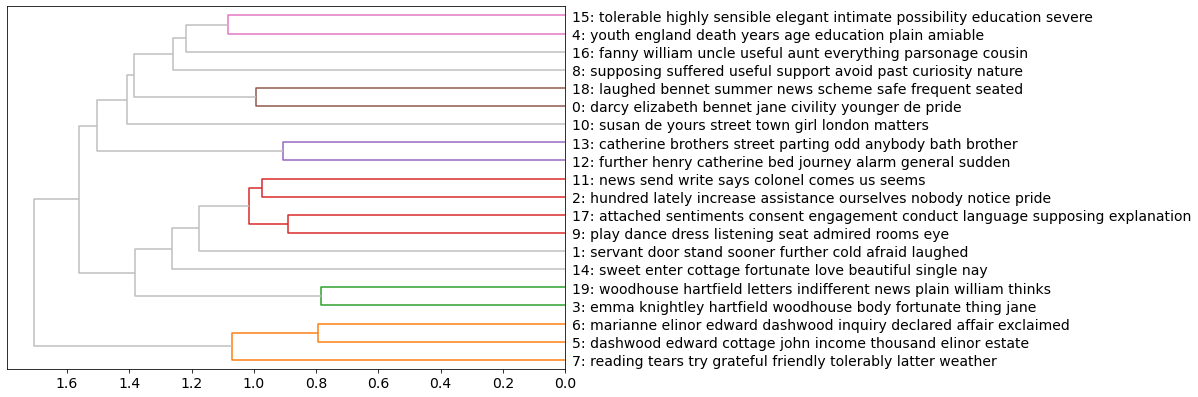

In [28]:
dend_aus_phi = HAC(tm_aus.PHI)
dend_aus_phi.labels = tm_aus.TOPIC.label.to_list()
dend_aus_phi.plot()

<Figure size 432x288 with 0 Axes>

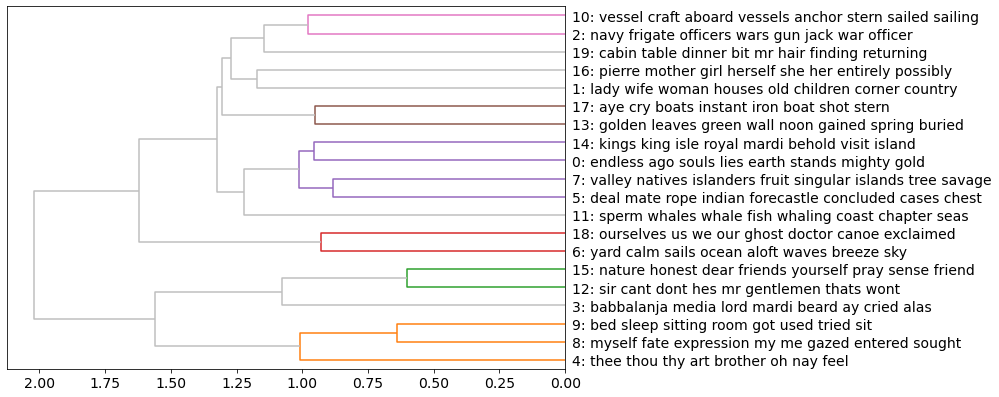

In [29]:
dend_mel_phi = HAC(tm_mel.PHI)
dend_mel_phi.labels = tm_mel.TOPIC.label.to_list()
dend_mel_phi.plot()

## Heatmaps of Topics within Books

In [52]:
def show_book_heatmap(tm, book_id, h=None, w=None, thresh=None):
    global LIB
    
    title = LIB.loc[book_id].label

    # Pick only those topics whose mean concentration is above threshhold
    if not thresh:
        thresh = tm.THETA.loc[book_id].mean().quantile(.8)
    X = tm.THETA.loc[book_id, tm.THETA.loc[book_id].mean() >= thresh]
    if not h:
        h = int(75 * len(X.T))
    if not w:
        w = int(16 * len(X))
    if w < 1000: w = 1000
    return px.imshow(X.T, 
                     width=w, height=h, aspect='equal',
                     color_continuous_scale='GnBu', 
                     labels=dict(y='topics',x='chapters'),
                     y=tm.TOPIC.loc[X.columns].label.values,
                     title=f"{title} / thresh={round(thresh, 2)}" 
    )

In [53]:
LIB.loc[AUS_IDX].title

book_id
105               PERSUASION
121         NORTHANGER ABBEY
141           MANSFIELD PARK
158                     EMMA
161     SENSE AND SENSIBILIT
946               LADY SUSAN
1212    LOVE AND FREINDSHIP 
1342     PRIDE AND PREJUDICE
Name: title, dtype: object

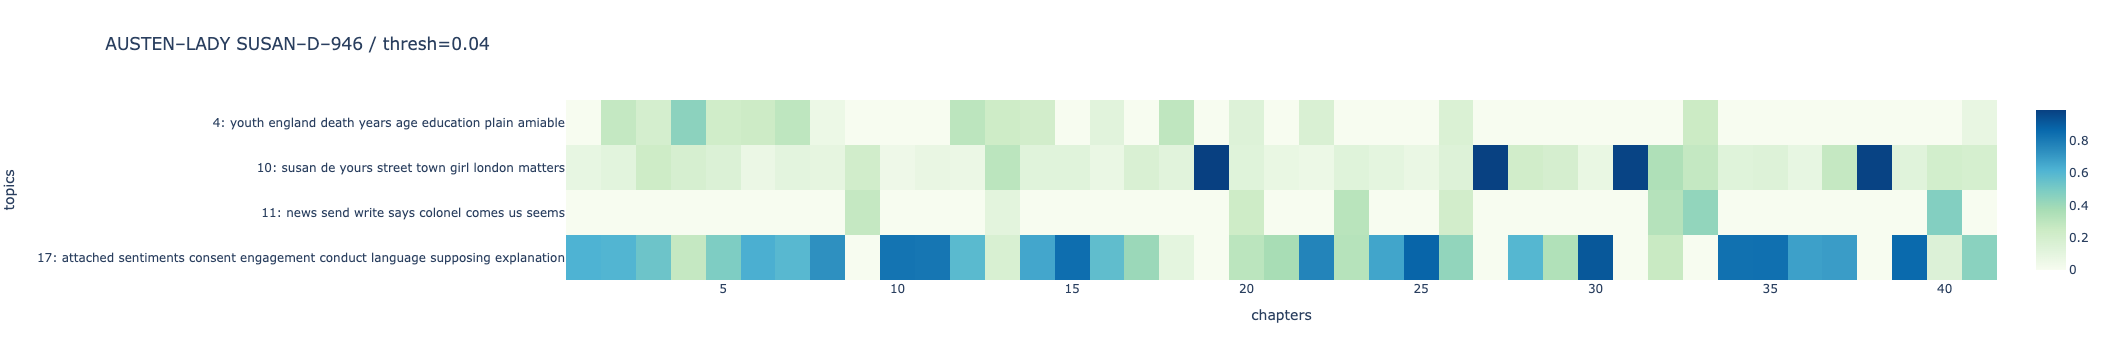

In [55]:
show_book_heatmap(tm_aus, 946)

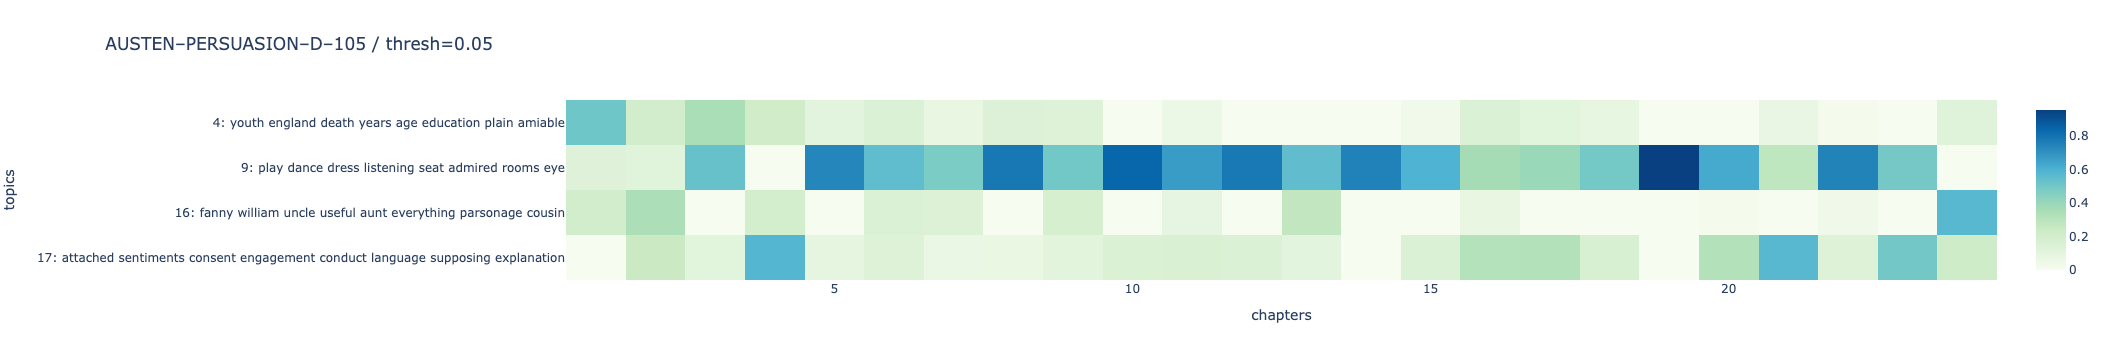

In [56]:
show_book_heatmap(tm_aus, 105, w=1000)

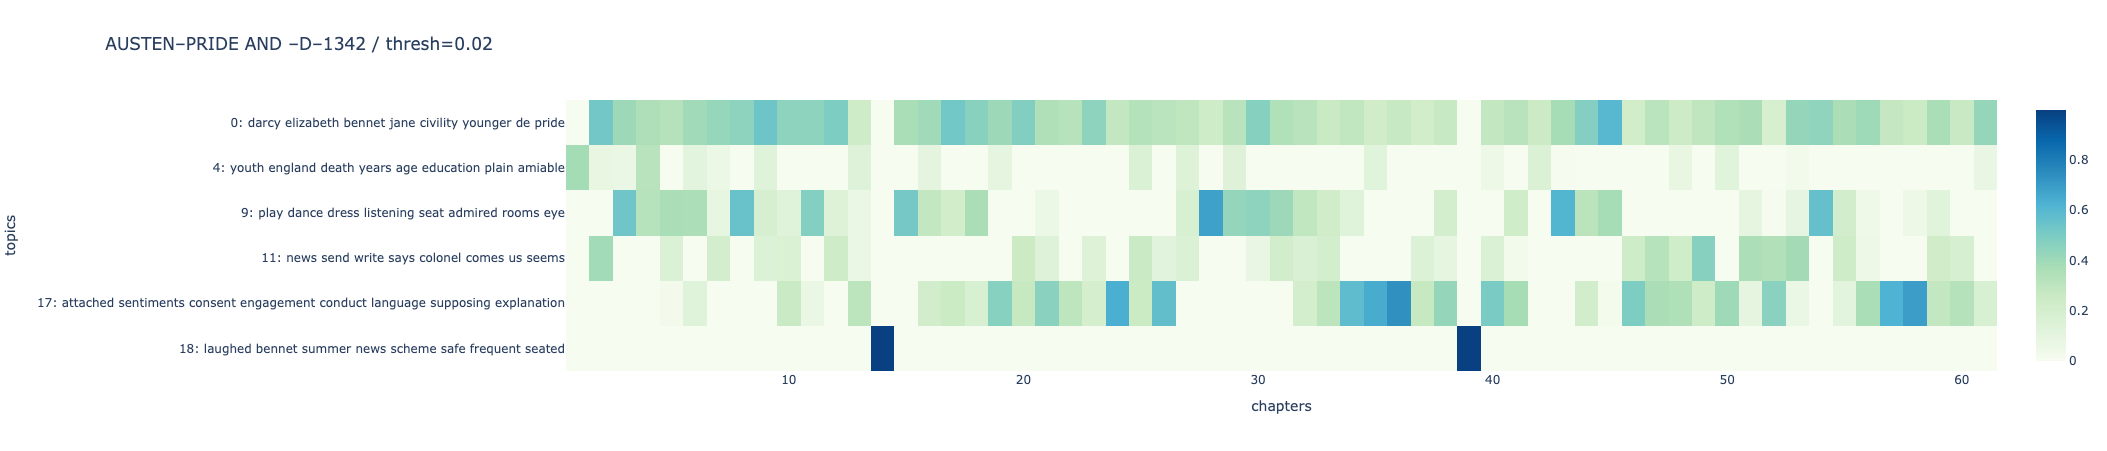

In [57]:
show_book_heatmap(tm_aus, 1342, thresh=.02)

In [35]:
LIB.loc[MEL_IDX].title

book_id
1900     TYPEE A ROMANCE OF T
2701     MOBY DICK OR THE WHA
4045     OMOO ADVENTURES IN T
8118     REDBURN HIS FIRST VO
10712    WHITE JACKET OR THE 
13720    MARDI AND A VOYAGE T
13721    MARDI AND A VOYAGE T
15422    ISRAEL POTTER HIS FI
21816    THE CONFIDENCE MAN H
34970    PIERRE OR THE AMBIGU
Name: title, dtype: object

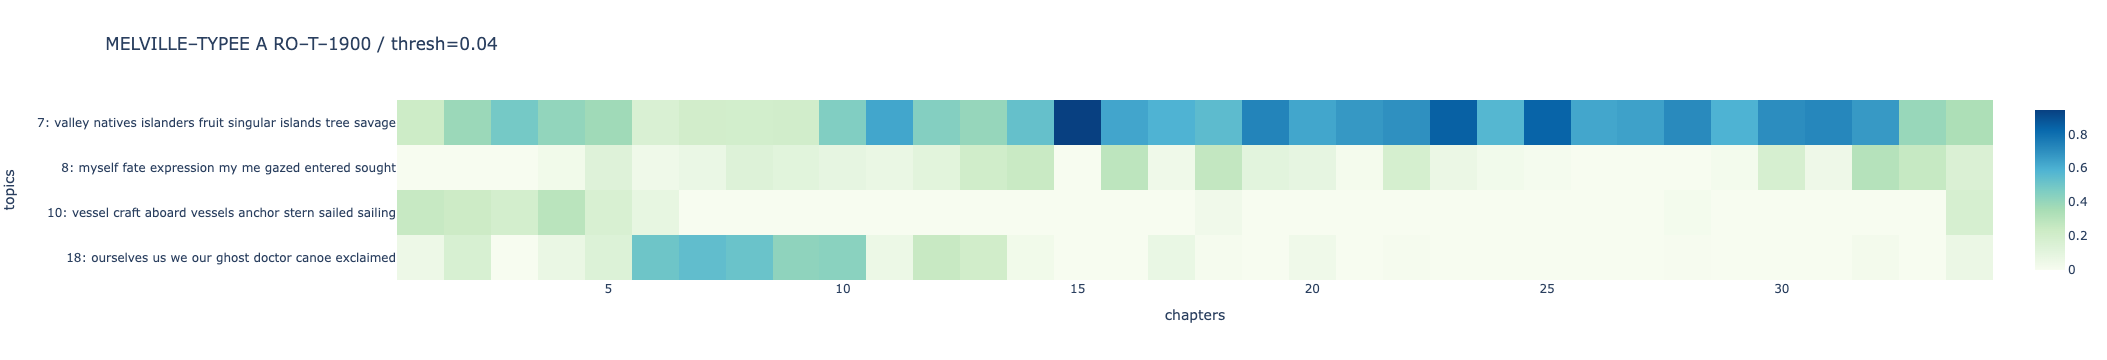

In [58]:
show_book_heatmap(tm_mel, 1900)

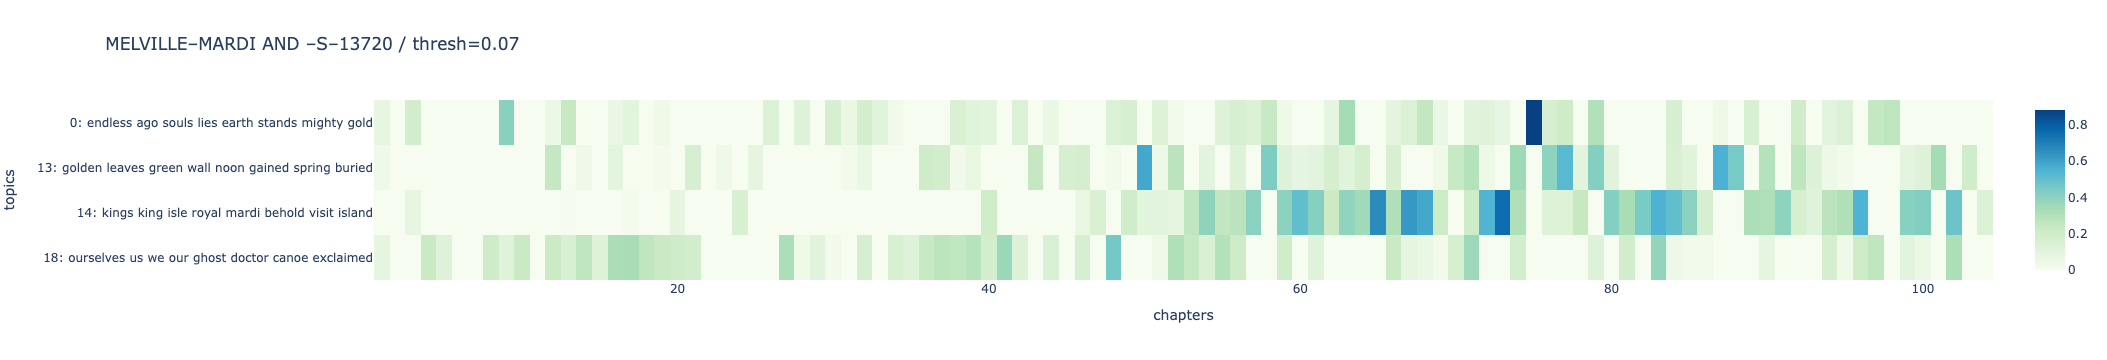

In [59]:
show_book_heatmap(tm_mel, 13720)

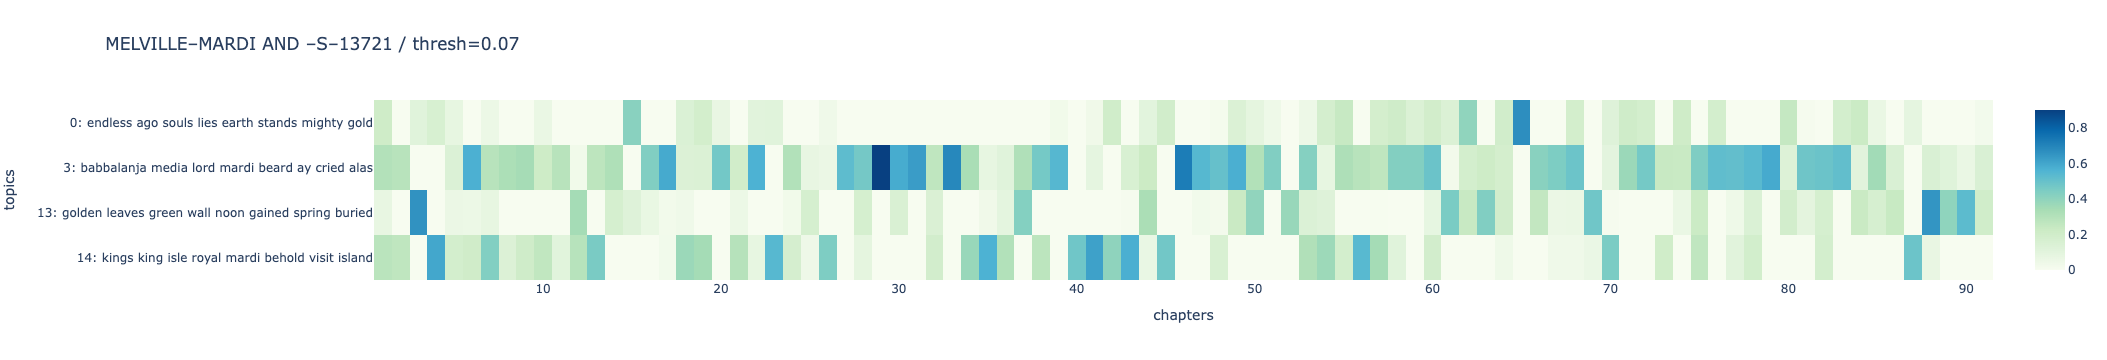

In [60]:
show_book_heatmap(tm_mel, 13721, w=1500)

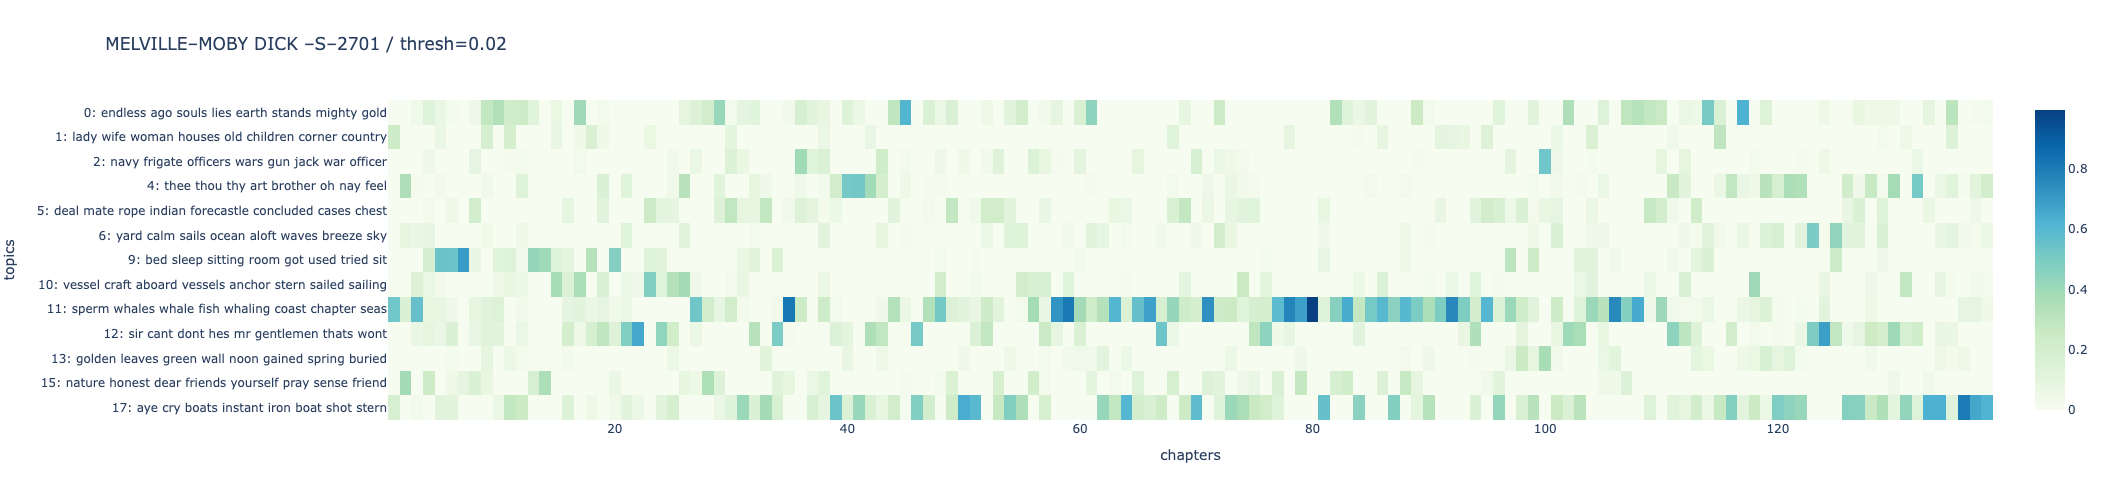

In [63]:
show_book_heatmap(tm_mel, 2701, thresh=.02, h=500)

# Visualize with t-SNE

In [64]:
from sklearn.manifold import TSNE

In [95]:
def plot_phi(model):
    X = model.PHI
    pp = model.TOPIC.h.mean()
    print(pp)
    T = model.TOPIC.join(pd.DataFrame(TSNE(n_components=2, learning_rate='auto', perplexity=pp, init='random').fit_transform(X)))
    fig = px.scatter(T, 0, 1, width=600, height=500, 
                     size=f'phi_sum', 
                     hover_name='label', 
                     text=model.TOPIC.index)  
    fig.show()

8.426


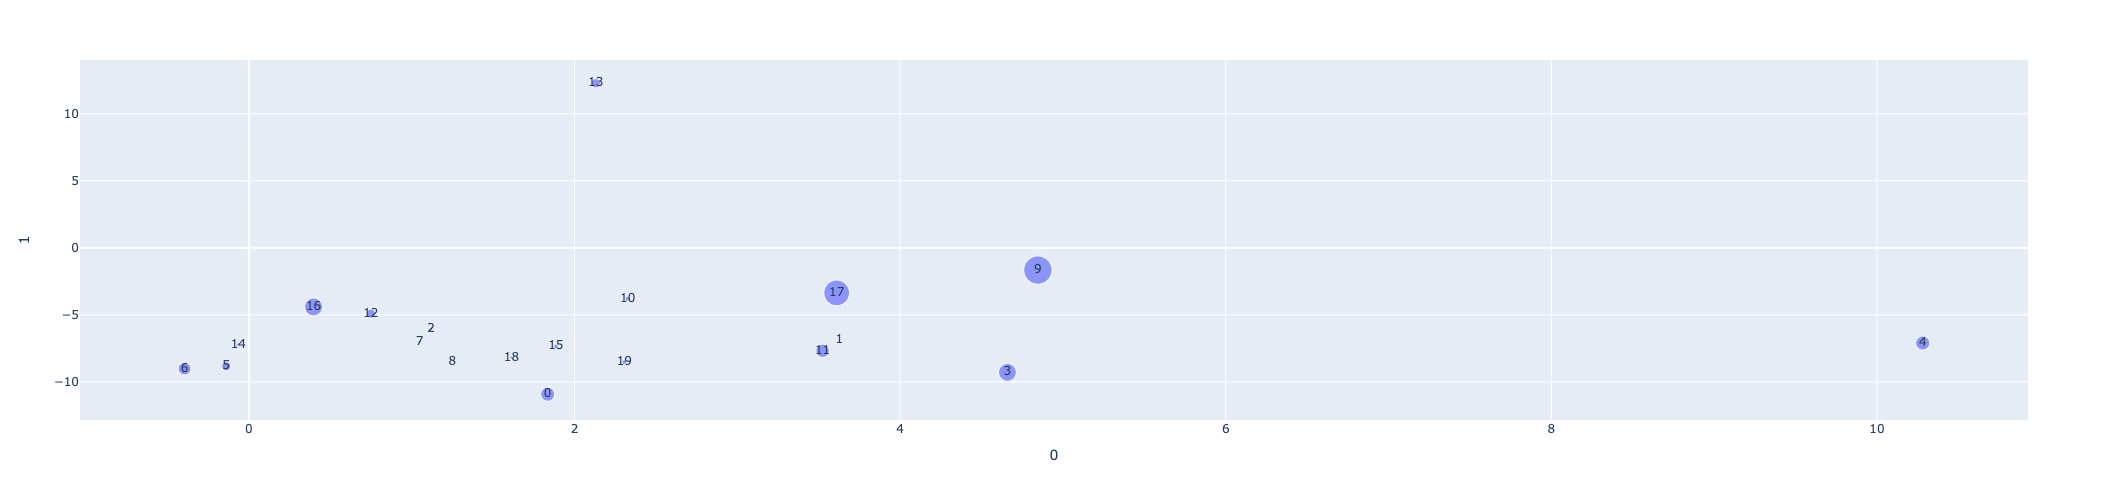

In [96]:
plot_phi(tm_aus)

8.024499999999998


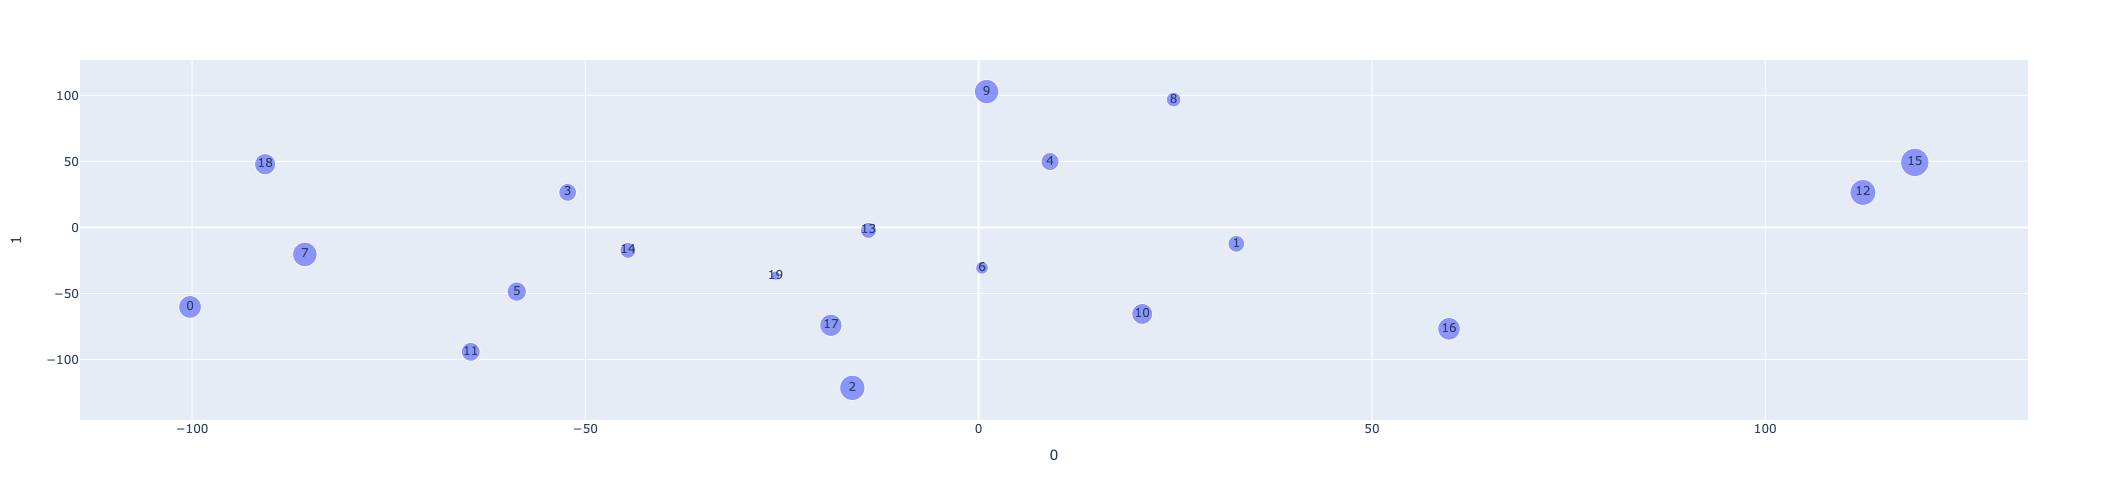

In [97]:
plot_phi(tm_mel)

In [106]:
def plot_theta(model):
    X = model.THETA
    pp = n_topics
    T = pd.DataFrame(TSNE(n_components=2, learning_rate='auto', perplexity=pp, init='random').fit_transform(X), index=X.index)
    T = T.join(model.DOC)
    fig = px.scatter(T, 0, 1, height=1000, width=1200, 
               hover_name=T.label, 
               color='title', 
               marginal_x='box', 
               marginal_y='box'
          )    
    fig.show()

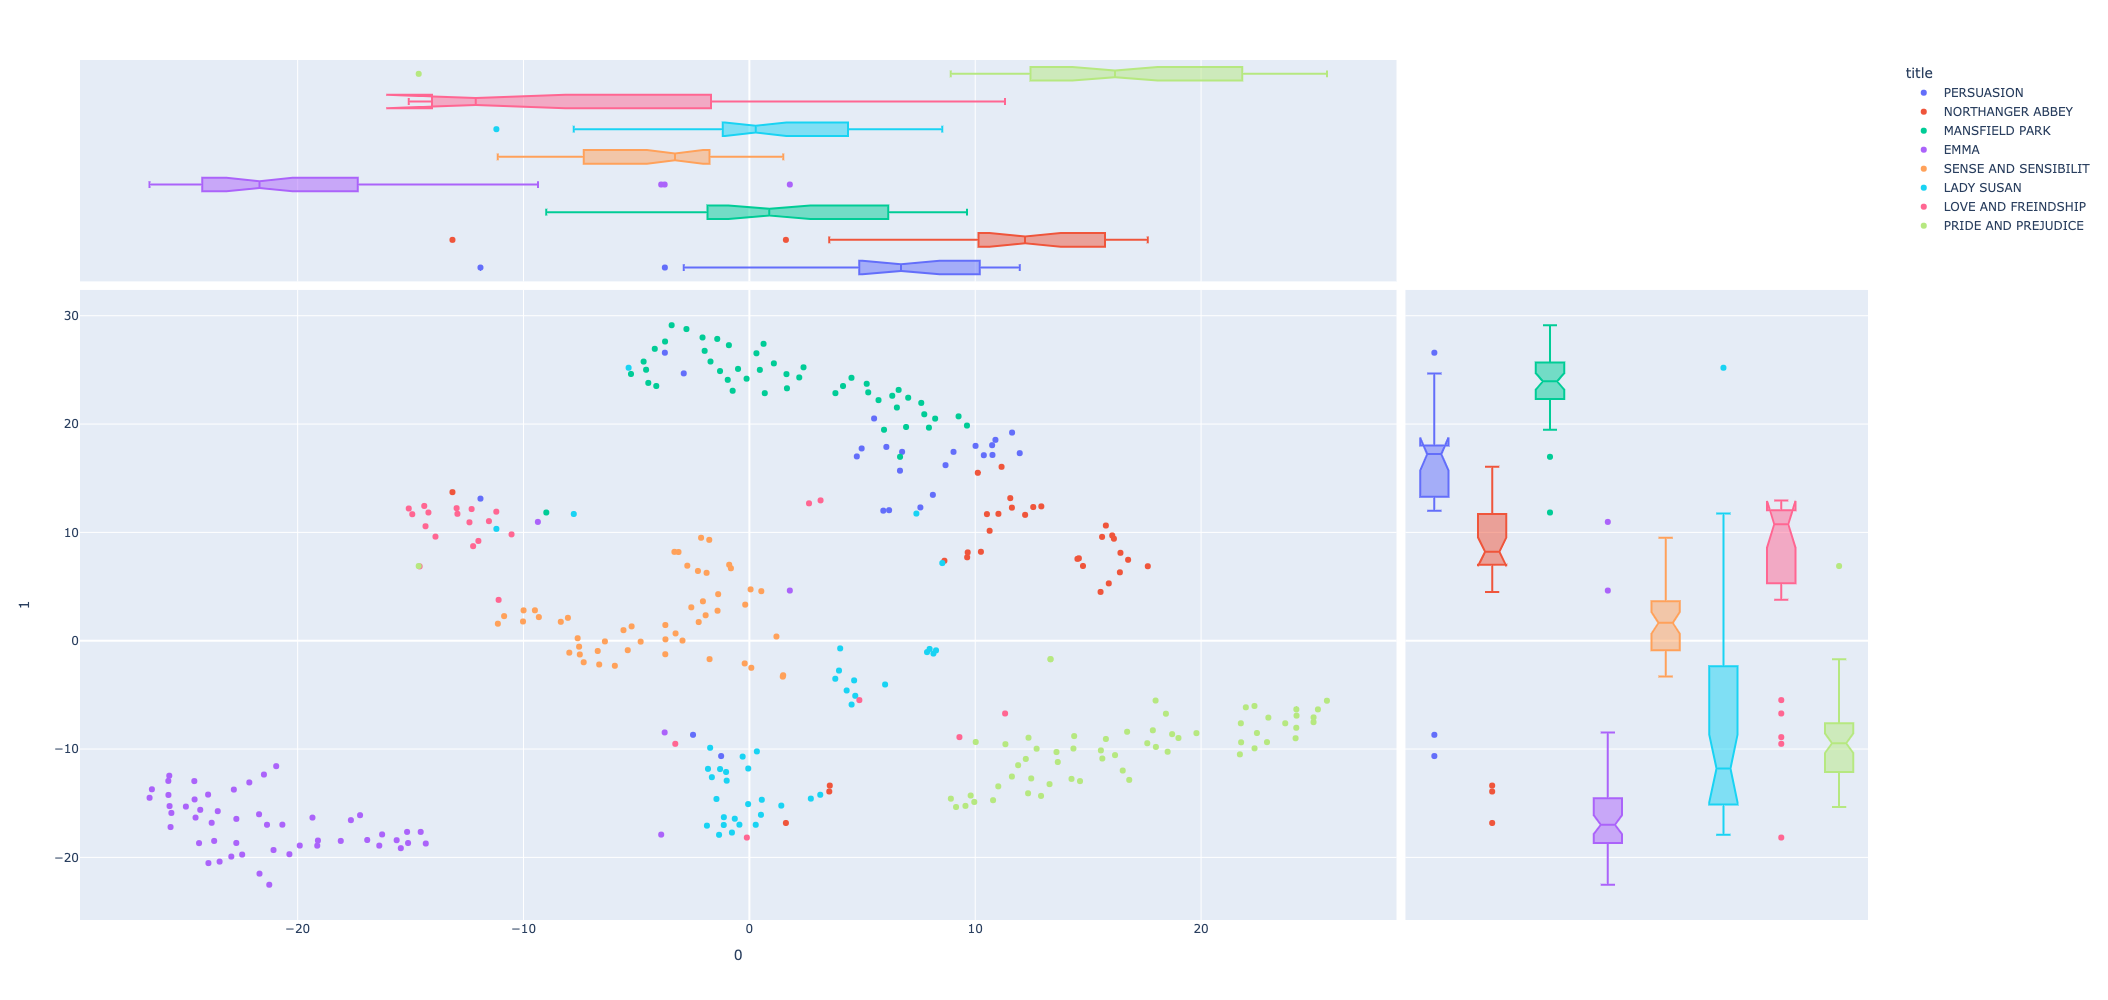

In [107]:
plot_theta(tm_aus)

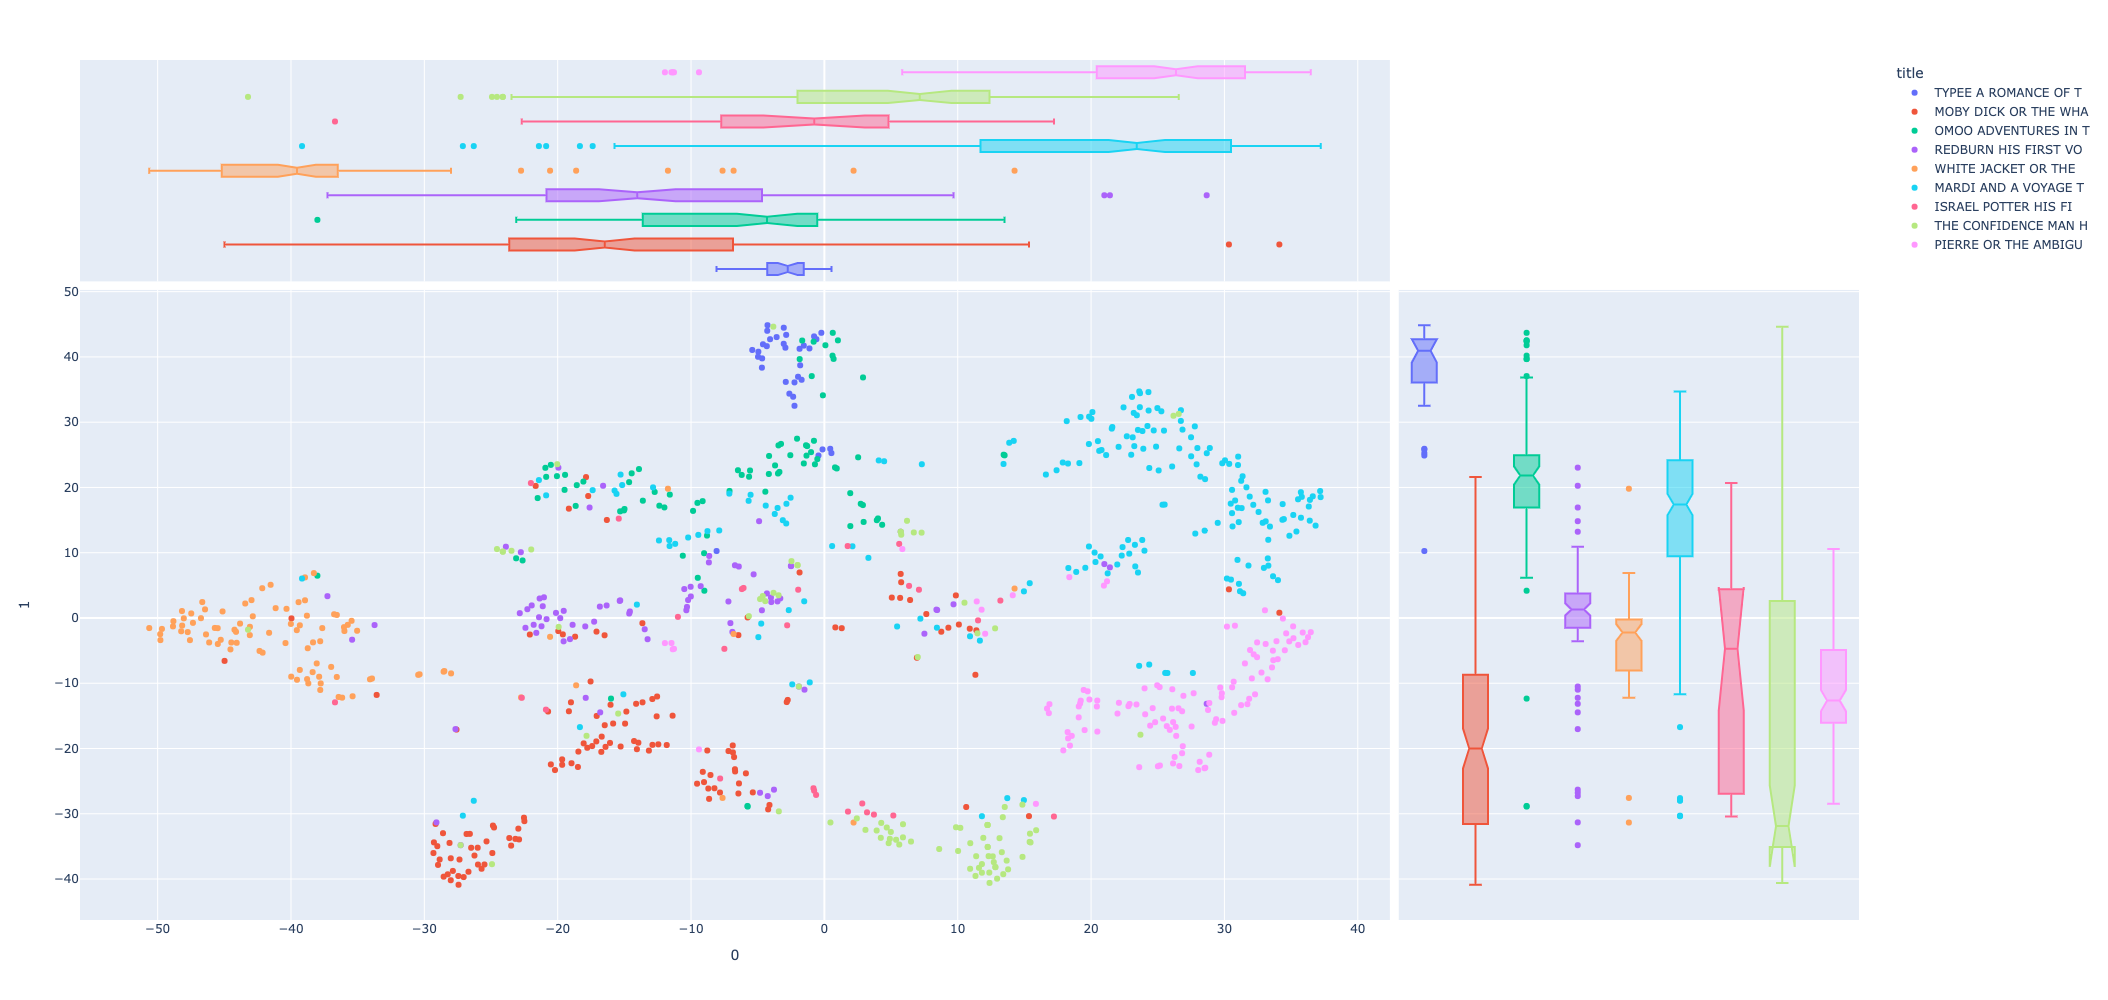

In [108]:
plot_theta(tm_mel)

# Save

In [73]:
tm_aus.TOPIC.to_csv(f'{data_home}/output/austen-LDA_TOPIC-{n_topics}.csv')
tm_aus.THETA.to_csv(f'{data_home}/output/austen-LDA_THETA-{n_topics}.csv')
tm_aus.PHI.to_csv(f'{data_home}/output/austen-LDA_PHI-{n_topics}.csv')

In [74]:
tm_mel.TOPIC.to_csv(f'{data_home}/output/melville-LDA_TOPIC-{n_topics}.csv')
tm_mel.THETA.to_csv(f'{data_home}/output/melville-LDA_THETA-{n_topics}.csv')
tm_mel.PHI.to_csv(f'{data_home}/output/melville-LDA_PHI-{n_topics}.csv')